In [1]:
import uproot
import pandas as pd
import numpy as np


In [2]:
with uproot.open('toyXic2pKpi_20mln.root') as noasym_datafile:
    data_df = noasym_datafile['R0Tree'].arrays(library='pd')

In [3]:
data_df.columns

Index(['m2pk', 'm2kpi', 'id', 'sample'], dtype='object')

In [4]:
combined_data_id = data_df[['m2pk', 'm2kpi', 'id']].copy()

particles     = combined_data_id[combined_data_id['id'] == 1]
antiparticles = combined_data_id[combined_data_id['id'] == -1]

# data sets with two columns only
particles_xy = particles[['m2pk', 'm2kpi']].copy()  
antiparticles_xy = antiparticles[['m2pk', 'm2kpi']].copy()
combined_data_xy = combined_data_id[['m2pk', 'm2kpi']].copy()  

print(particles.head())
print(antiparticles.head())
print(combined_data_id.head())

print('\n particles = ', len(particles))
print(' antiparticles = ', len(antiparticles))
    
print(particles_xy.head())
print(antiparticles_xy.head())
print(combined_data_xy.head())

       m2pk     m2kpi  id
0  3.460569  0.673391   1
1  3.075171  0.761314   1
2  2.746258  1.339751   1
3  2.190463  2.049242   1
4  3.988466  0.707543   1
              m2pk     m2kpi  id
10000000  3.524324  2.084737  -1
10000001  3.497870  1.261757  -1
10000002  2.418601  1.440717  -1
10000003  3.495933  1.956262  -1
10000004  2.284854  2.110827  -1
       m2pk     m2kpi  id
0  3.460569  0.673391   1
1  3.075171  0.761314   1
2  2.746258  1.339751   1
3  2.190463  2.049242   1
4  3.988466  0.707543   1

 particles =  10000000
 antiparticles =  10000000
       m2pk     m2kpi
0  3.460569  0.673391
1  3.075171  0.761314
2  2.746258  1.339751
3  2.190463  2.049242
4  3.988466  0.707543
              m2pk     m2kpi
10000000  3.524324  2.084737
10000001  3.497870  1.261757
10000002  2.418601  1.440717
10000003  3.495933  1.956262
10000004  2.284854  2.110827
       m2pk     m2kpi
0  3.460569  0.673391
1  3.075171  0.761314
2  2.746258  1.339751
3  2.190463  2.049242
4  3.988466  0.707543


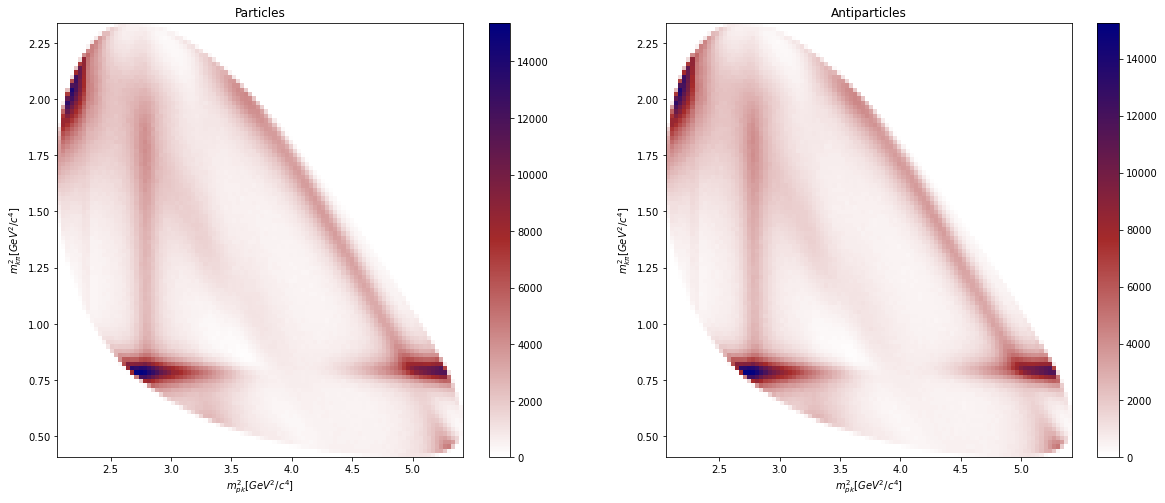

In [5]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "brown", "navy"])

hist_particles = axs[0].hist2d(particles['m2pk'], particles['m2kpi'], bins=100, cmap=cmap)
axs[0].set_title('Particles')
axs[0].set_xlabel('$m_{pk}^2[GeV^2/c^4]$')
axs[0].set_ylabel('$m_{k\pi}^2[GeV^2/c^4]$')
fig.colorbar(hist_particles[3], ax=axs[0])

hist_antiparticles = axs[1].hist2d(antiparticles['m2pk'], antiparticles['m2kpi'], bins=100, cmap=cmap)
axs[1].set_title('Antiparticles')
axs[1].set_xlabel('$m_{pk}^2[GeV^2/c^4]$')
axs[1].set_ylabel('$m_{k\pi}^2[GeV^2/c^4]$')
fig.colorbar(hist_antiparticles[3], ax=axs[1])

plt.show() 

In [6]:
from sklearn.neighbors import NearestNeighbors

# Parameters
k = 50  # number of nearest neighbors

# Function to compute T statistic
def compute_T_statistic(X, labels, k):
    n_total = len(X)
    n_plus = np.sum(labels == 1)
    n_minus = np.sum(labels == 0)

    # Fit kNN
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Count same-label neighbors (exclude self at index 0)
    same_label_counts = []
    for i in range(n_total):
        neighbors = indices[i][1:]  # exclude self
        same = np.sum(labels[neighbors] == labels[i])
        same_label_counts.append(same)

    T = np.sum(same_label_counts) / (k * n_total)

    # Expected mean and variance under null hypothesis
    T_R = (n_plus * (n_plus - 1) + n_minus * (n_minus - 1)) / (n_total * (n_total - 1))
    sigma_T2 = (1 / (n_total * k)) * ((n_plus**2 + n_minus**2) / n_total**2 - T_R**2)
    sigma_T = np.sqrt(sigma_T2)

    pull = (T - T_R) / sigma_T
    return T, T_R, sigma_T, pull


In [7]:
# create a labale column to id column for classification

data_df['label'] = (data_df['id'] == 1).astype(int)

# defining the region of dalitz plot

def assign_region(m2_kpi, m2_pk):
    if m2_kpi < 0.7:
        return 'R1'
    elif 0.7 <= m2_kpi < 0.9:
        if m2_pk < 4.0:
            return 'R8'
        else:
            return 'R9'
    elif 0.9 <= m2_kpi < 1.3:
        return 'R3'
    elif m2_kpi >= 1.3:
        if m2_pk < 2.4:
            return 'R4'
        elif 2.4 <= m2_pk < 3.2:
            return 'R5'
        elif 3.2 <= m2_pk < 3.8:
            return 'R6'
        else:
            return 'R7'
    return 'R0'


data_df['region'] = data_df.apply(lambda row: assign_region(row['m2kpi'], row['m2pk']), axis=1)

results = []
for region in sorted(data_df['region'].unique()):
    region_df = data_df[data_df['region'] == region]
    if len(region_df) < 2 * k:
        continue  

    X_region = region_df[['m2kpi', 'm2pk']].values
    y_region = region_df['label'].values

    T, T_R, sigma_T, pull = compute_T_statistic(X_region, y_region, k)
    results.append({'Region': region, 'T': T, 'T_R': T_R, 'σ_T': sigma_T, 'Pull': pull})

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Region'))


  Region         T       T_R       σ_T      Pull
0     R1  0.500085  0.500001  0.000056  1.510701
1     R3  0.499965  0.500000  0.000039 -0.905932
2     R4  0.500053  0.500000  0.000043  1.216518
3     R5  0.500008  0.500000  0.000034  0.221697
4     R6  0.499957  0.500000  0.000052 -0.838179
5     R7  0.500071  0.500000  0.000057  1.247242
6     R8  0.500026  0.500000  0.000044  0.587143
7     R9  0.499959  0.500000  0.000049 -0.831993


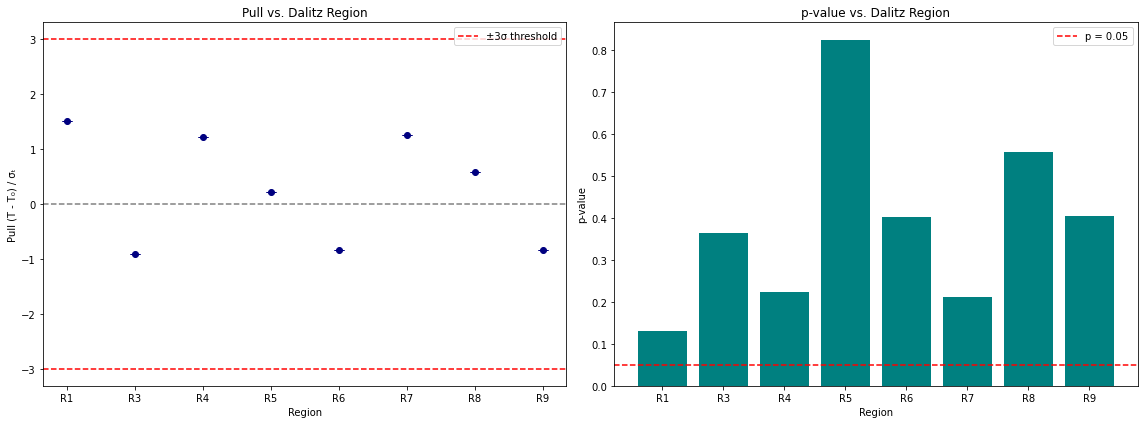

In [9]:
from scipy.stats import norm


# Compute p-values from pull
results_df['p_value'] = 2 * (1 - norm.cdf(np.abs(results_df['Pull'])))
results_df = results_df.sort_values(by='Region')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


axs[0].errorbar(results_df['Region'], results_df['Pull'], yerr=results_df['σ_T'],
                fmt='o', capsize=5, color='navy')
axs[0].axhline(0, color='gray', linestyle='--')
axs[0].axhline(3, color='red', linestyle='--', label='±3σ threshold')
axs[0].axhline(-3, color='red', linestyle='--')
axs[0].set_title('Pull vs. Dalitz Region')
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Pull (T - T₀) / σₜ')
axs[0].legend()


axs[1].bar(results_df['Region'], results_df['p_value'], color='teal')
axs[1].axhline(0.05, color='red', linestyle='--', label='p = 0.05')
axs[1].set_title('p-value vs. Dalitz Region')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('p-value')
#axs[1].set_yscale('log')  # log scale to highlight small p-values
axs[1].legend()


plt.tight_layout()
plt.show()

